In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from DLC_for_WBFM.utils.projects.finished_project_data import ProjectData
import napari
import pandas as pd
import numpy as np
from DLC_for_WBFM.utils.feature_detection.class_frame_pair import FramePair



Bad key "text.kerning_factor" on line 4 in
/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
fname = "/scratch/zimmer/Charles/dlc_stacks/worm10-gui_test/project_config.yaml"
project_data = ProjectData.load_final_project_data_from_config(fname, to_load_tracklets=True, to_load_segmentation_metadata=True)

Output files for annotator: /scratch/zimmer/Charles/dlc_stacks/worm10-gui_test/3-tracking/manual_annotation/global2tracklet_manual.pickle, /scratch/zimmer/Charles/dlc_stacks/worm10-gui_test/3-tracking/manual_annotation/manually_split_tracklets.h5, /scratch/zimmer/Charles/dlc_stacks/worm10-gui_test/3-tracking/manual_annotation/split_names.pickle, /scratch/zimmer/Charles/dlc_stacks/worm10-gui_test/3-tracking/manual_annotation/split_times.pickle
Project data for directory:
/scratch/zimmer/Charles/dlc_stacks/worm10-gui_test 
Found the following raw data files:
red_data:                 True
green_data:               True
============Segmentation===============
raw_segmentation:         True
segmentation:             False
============Tracklets==================
df_training_tracklets:    True
reindexed_masks_training: True
============Traces=====================
red_traces:               False
green_traces:             False
final_tracks:             True
behavior_annotations:     False



In [3]:
# fname = "/home/charles/dlc_stacks/worm3-tracklet_wiggle/project_config.yaml"
# project_data2 = ProjectData.load_final_project_data_from_config(fname, to_load_tracklets=True, to_load_segmentation_metadata=True)

In [4]:
# project_data2.red_traces.head()

# Initialize neurons, order tracklets to get candidates, and add tracklets in a loop

### Initialize

In [158]:
from DLC_for_WBFM.utils.pipeline.tracklet_class import TrackedWorm
from DLC_for_WBFM.utils.training_data.tracklet_to_DLC import translate_training_names_to_raw_names
from tqdm.auto import tqdm

In [159]:
tracklets_and_neurons_class = project_data.tracklets_and_neurons_class
worm_obj = TrackedWorm(detections=tracklets_and_neurons_class, verbose=1)
df_training_data = project_data.df_training_tracklets

In [160]:
worm_obj.initialize_neurons_from_training_data(df_training_data)

In [161]:
worm_obj

Worm with 144 neurons

In [9]:
# worm_obj.global_name_to_neuron

### Order the tracklets and do many-to-one matching

In [141]:
from DLC_for_WBFM.utils.postprocessing.combine_tracklets_and_DLC_tracks import calc_global_track_to_tracklet_distances
from DLC_for_WBFM.utils.external.utils_pandas import dataframe_to_dataframe_zxy_format
from DLC_for_WBFM.utils.external.utils_networkx import dist2conf

In [177]:
del project_data.intermediate_global_tracks

In [178]:
df_global_tracks = project_data.intermediate_global_tracks
# df_global_tracks[('neuron_007', 'z')].replace(0.0, np.nan).plot()

In [126]:

df_tracklets = project_data.df_all_tracklets
# Pre-make coordinates so that the dataframe is not continuously indexed
coords = ['z', 'x', 'y']
all_tracklet_names = list(df_tracklets.columns.levels[0])
list_tracklets_zxy = [df_tracklets[name][coords].to_numpy() for name in tqdm(all_tracklet_names)]

  0%|          | 0/15702 [00:00<?, ?it/s]

In [127]:
min_overlap = 5
d_max = 5
used_names = []

In [128]:
worm_obj.initialize_all_neuron_tracklet_classifiers()

In [142]:
# For each neuron, calculate all tracklet distances (percent inliers)
# If passes threshold 1:
#   Then check z/volume threshold 2:
#     Directly add the tracklets to the neurons within worm_obj
#   Else simply do not add
# Finally, do b_matching

for name, neuron in tqdm(worm_obj.global_name_to_neuron.items()):
    # For now just use the tracklet as defined by the training data
    # this_global_track = worm_obj.get_tracklets_for_neuron(name)[0]
    # this_global_track = this_global_track[coords].to_numpy(float)
    
    # New: use the track as produced by the global tracking
    # TODO: confirm that the worm_obj has the same neuron names as leifer
    this_global_track = df_global_tracks[name][coords][:-1].replace(0.0, np.nan).to_numpy(float)
    
    # TODO: calculate distance using percent inliers
    dist = calc_global_track_to_tracklet_distances(this_global_track, list_tracklets_zxy, all_tracklet_names, used_names,
                                                   min_overlap=min_overlap)
    
    # Loop through candidates, and attempt to add
    all_summarized_dist = list(map(lambda x: np.nanquantile(x, 0.1), dist))
    i_sorted_by_median_distance = np.argsort(all_summarized_dist)
    
    for i_tracklet in i_sorted_by_median_distance:
        # Check distance; break because they are sorted by distance
        this_distance = all_summarized_dist[i_tracklet]
        if this_distance > d_max:
            print(f"Breaking at distance: {this_distance}")
            break
        
        candidate_name = all_tracklet_names[i_tracklet]
        candidate_tracklet = df_tracklets[[candidate_name]]
        conf = dist2conf(this_distance)
        is_match_added = neuron.add_tracklet(i_tracklet, conf, candidate_tracklet, metadata=candidate_name,
                                             check_using_classifier=True)
        
        if is_good:
            print(f"Adding tracklet: {candidate_name} with distance {this_distance}")
        else:
            print(f"Not adding {candidate_name}")
        
    break

  0%|          | 0/144 [00:00<?, ?it/s]

Adding tracklet: tracklet_0002118
0.0
Adding tracklet: tracklet_0008759
0.0
Adding tracklet: tracklet_0010753
0.0
Adding tracklet: tracklet_0008866
0.0
Adding tracklet: tracklet_0008891
0.0
Adding tracklet: tracklet_0003913
0.0
Adding tracklet: tracklet_0018447
0.0
Adding tracklet: tracklet_0003830
0.0
Adding tracklet: tracklet_0003826
0.0
Adding tracklet: tracklet_0003715
0.0
Adding tracklet: tracklet_0001377
0.0
Adding tracklet: tracklet_0018384
0.0
Adding tracklet: tracklet_0003593
0.0
Adding tracklet: tracklet_0013444
0.0
Adding tracklet: tracklet_0018337
0.0
Adding tracklet: tracklet_0003366
0.0
Adding tracklet: tracklet_0003323
0.0
Adding tracklet: tracklet_0009253
0.0
Adding tracklet: tracklet_0013358
0.0
Adding tracklet: tracklet_0007143
0.0
Adding tracklet: tracklet_0001548
0.0
Adding tracklet: tracklet_0007134
0.0
Adding tracklet: tracklet_0015120
0.0
Adding tracklet: tracklet_0001672
0.0
Adding tracklet: tracklet_0011621
0.0
Adding tracklet: tracklet_0011623
0.0
Adding track

In [109]:
from DLC_for_WBFM.utils.pipeline.long_range_matching import b_matching_via_node_copying
from DLC_for_WBFM.utils.pipeline.long_range_matching import combine_tracklets_using_matching

In [ ]:
global_tracklet_neuron_graph = worm_obj.compose_global_neuron_and_tracklet_graph()
final_matching = b_matching_via_node_copying(global_tracklet_neuron_graph)
df_new = combine_tracklets_using_matching(all_tracklet_names, df_tracklets, final_matching)

# Same, using functions

In [147]:
project_path = project_data.project_config.self_path

In [150]:
from DLC_for_WBFM.utils.pipeline.long_range_matching import global_track_matches_from_config
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.debug("test")

DEBUG:root:test


In [172]:
df_new, final_matching, global_tracklet_neuron_graph, worm_obj = global_track_matches_from_config(project_path, to_save=True, verbose=2)

INFO:root:File for mode automatic exists at precendence: 1/3
INFO:root:Read data from: /scratch/zimmer/Charles/dlc_stacks/worm10-gui_test/3-tracking/postprocessing/leifer_tracks.h5
INFO:root:Using most recently modified file
INFO:root:Starting threads to read data...
INFO:root:First time loading the all tracklets, may take a while...
INFO:root:File for mode automatic exists at precendence: 3/3
INFO:root:Read data from: /scratch/zimmer/Charles/dlc_stacks/worm10-gui_test/2-training_data/all_tracklets.h5
INFO:root:Using most recently modified file
INFO:root:Found no files of possibilities: {'manual': '/scratch/zimmer/Charles/dlc_stacks/worm10-gui_test/3-tracking/manual_annotation/global2tracklet_manual.pickle', 'automatic': '/scratch/zimmer/Charles/dlc_stacks/worm10-gui_test/3-tracking/global2tracklet.pickle'}
INFO:root:First time loading the raw cluster dataframe, may take a while...


Output files for annotator: /scratch/zimmer/Charles/dlc_stacks/worm10-gui_test/3-tracking/manual_annotation/global2tracklet_manual.pickle, /scratch/zimmer/Charles/dlc_stacks/worm10-gui_test/3-tracking/manual_annotation/manually_split_tracklets.h5, /scratch/zimmer/Charles/dlc_stacks/worm10-gui_test/3-tracking/manual_annotation/split_names.pickle, /scratch/zimmer/Charles/dlc_stacks/worm10-gui_test/3-tracking/manual_annotation/split_times.pickle


INFO:root:Read all data


Project data for directory:
/scratch/zimmer/Charles/dlc_stacks/worm10-gui_test 
Found the following data files:
============Raw========================
red_data:                 True
green_data:               True
============Annotations================
behavior_annotations:     False
============Training================
df_training_tracklets:    True
============Segmentation===============
raw_segmentation:         True
colored_segmentation:     False
============Traces=====================
red_traces:               False
green_traces:             False

Initialized worm object: Worm with 144 neurons


  0%|          | 0/15702 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_001 (index=0) with 19 tracklets from time 1656 to 1479


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_002 (index=1) with 36 tracklets from time 1659 to 1736


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_003 (index=2) with 130 tracklets from time 1659 to 1267


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_004 (index=3) with 20 tracklets from time 1659 to 1017


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_005 (index=4) with 58 tracklets from time 1659 to 935


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_006 (index=5) with 10 tracklets from time 1659 to 2499


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_007 (index=6) with 74 tracklets from time 1659 to 628


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_008 (index=7) with 49 tracklets from time 1659 to 2095


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_009 (index=8) with 89 tracklets from time 1660 to 1215


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_010 (index=9) with 33 tracklets from time 1660 to 1374


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_011 (index=10) with 20 tracklets from time 1660 to 137


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_012 (index=11) with 18 tracklets from time 1660 to 2499


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_013 (index=12) with 18 tracklets from time 1660 to 668


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_014 (index=13) with 20 tracklets from time 1660 to 451


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_015 (index=14) with 16 tracklets from time 1660 to 1495


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_016 (index=15) with 106 tracklets from time 1660 to 1085


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_017 (index=16) with 18 tracklets from time 1660 to 1426


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_018 (index=17) with 40 tracklets from time 1764 to 662


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_019 (index=18) with 41 tracklets from time 1766 to 291


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_020 (index=19) with 36 tracklets from time 1771 to 880


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_021 (index=20) with 26 tracklets from time 1779 to 292


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_022 (index=21) with 36 tracklets from time 1801 to 1327


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_023 (index=22) with 48 tracklets from time 1813 to 681


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_024 (index=23) with 14 tracklets from time 1849 to 1785


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_025 (index=24) with 86 tracklets from time 1849 to 2365


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_026 (index=25) with 77 tracklets from time 1849 to 1753


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_027 (index=26) with 106 tracklets from time 1850 to 589


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_028 (index=27) with 131 tracklets from time 1851 to 2300


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_029 (index=28) with 7 tracklets from time 1857 to 2084


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_030 (index=29) with 28 tracklets from time 1860 to 2499


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_031 (index=30) with 3 tracklets from time 1861 to 1948


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_032 (index=31) with 52 tracklets from time 1869 to 1010


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_033 (index=32) with 110 tracklets from time 1870 to 68


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_034 (index=33) with 153 tracklets from time 1884 to 889


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_035 (index=34) with 145 tracklets from time 1885 to 2309


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_036 (index=35) with 48 tracklets from time 1891 to 896


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_037 (index=36) with 69 tracklets from time 1895 to 1176


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_038 (index=37) with 112 tracklets from time 1902 to 1091


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_039 (index=38) with 4 tracklets from time 1912 to 450


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_040 (index=39) with 108 tracklets from time 1927 to 335


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_041 (index=40) with 27 tracklets from time 1928 to 1599


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_042 (index=41) with 190 tracklets from time 1929 to 61


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_043 (index=42) with 14 tracklets from time 1936 to 369


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_044 (index=43) with 68 tracklets from time 1941 to 1531


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_045 (index=44) with 60 tracklets from time 1942 to 1380


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_046 (index=45) with 47 tracklets from time 1943 to 747


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_047 (index=46) with 157 tracklets from time 1947 to 1173


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_048 (index=47) with 18 tracklets from time 1947 to 89


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_049 (index=48) with 174 tracklets from time 1948 to 2452


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_050 (index=49) with 1 tracklets from time 1948 to 2007


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_051 (index=50) with 119 tracklets from time 1951 to 55


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_052 (index=51) with 94 tracklets from time 1955 to 214


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_053 (index=52) with 29 tracklets from time 1958 to 1560


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_054 (index=53) with 20 tracklets from time 1959 to 1148


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_055 (index=54) with 130 tracklets from time 1960 to 2408


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_056 (index=55) with 126 tracklets from time 1960 to 1189


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_057 (index=56) with 40 tracklets from time 1961 to 479


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_058 (index=57) with 72 tracklets from time 1962 to 1451


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_059 (index=58) with 140 tracklets from time 1963 to 1730


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_060 (index=59) with 105 tracklets from time 1963 to 1761


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_061 (index=60) with 35 tracklets from time 1963 to 1995


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_062 (index=61) with 38 tracklets from time 1963 to 1606


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_063 (index=62) with 97 tracklets from time 1964 to 670


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_064 (index=63) with 44 tracklets from time 1966 to 930


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_065 (index=64) with 78 tracklets from time 1967 to 1553


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_066 (index=65) with 25 tracklets from time 1967 to 293


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_067 (index=66) with 65 tracklets from time 1968 to 1639


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_068 (index=67) with 5900 tracklets from time 1968 to 870


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_069 (index=68) with 24 tracklets from time 1969 to 1162


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_070 (index=69) with 12 tracklets from time 1969 to 127


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_071 (index=70) with 1 tracklets from time 1969 to 2022
Tracklets added to make neuron: Neuron neuron_072 (index=71) with 109 tracklets from time 1970 to 1918


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_073 (index=72) with 99 tracklets from time 1971 to 1585


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_074 (index=73) with 44 tracklets from time 1971 to 2174


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_075 (index=74) with 71 tracklets from time 1971 to 1932


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_076 (index=75) with 122 tracklets from time 1973 to 1285


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_077 (index=76) with 38 tracklets from time 1973 to 170


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_078 (index=77) with 61 tracklets from time 1975 to 2373


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_079 (index=78) with 20 tracklets from time 1975 to 2433


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_080 (index=79) with 108 tracklets from time 1976 to 1781


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_081 (index=80) with 49 tracklets from time 1976 to 1306


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_082 (index=81) with 14 tracklets from time 1977 to 2208


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_083 (index=82) with 67 tracklets from time 1977 to 164


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_084 (index=83) with 90 tracklets from time 1977 to 1260


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_085 (index=84) with 74 tracklets from time 1978 to 589


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_086 (index=85) with 76 tracklets from time 1978 to 1389


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_087 (index=86) with 145 tracklets from time 1978 to 846


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_088 (index=87) with 5 tracklets from time 1978 to 2038


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_089 (index=88) with 2 tracklets from time 1978 to 1267


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_090 (index=89) with 75 tracklets from time 1979 to 2101


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_091 (index=90) with 24 tracklets from time 1979 to 43


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_092 (index=91) with 92 tracklets from time 1979 to 272


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_093 (index=92) with 157 tracklets from time 1979 to 1781


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_094 (index=93) with 12 tracklets from time 1980 to 143


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_095 (index=94) with 31 tracklets from time 1980 to 100


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_096 (index=95) with 24 tracklets from time 1980 to 1736


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_097 (index=96) with 55 tracklets from time 1980 to 1414


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_098 (index=97) with 71 tracklets from time 1980 to 1861


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_099 (index=98) with 23 tracklets from time 1981 to 1569


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_100 (index=99) with 86 tracklets from time 1982 to 826


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_101 (index=100) with 51 tracklets from time 1982 to 203


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_102 (index=101) with 49 tracklets from time 1982 to 284


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_103 (index=102) with 95 tracklets from time 1982 to 554


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_104 (index=103) with 48 tracklets from time 1983 to 1534


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_105 (index=104) with 62 tracklets from time 1983 to 412


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_106 (index=105) with 125 tracklets from time 1983 to 1521


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_107 (index=106) with 25 tracklets from time 1984 to 2477


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_108 (index=107) with 7 tracklets from time 1984 to 2110


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_109 (index=108) with 30 tracklets from time 1984 to 2136


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_110 (index=109) with 25 tracklets from time 1985 to 2138


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_111 (index=110) with 72 tracklets from time 1985 to 748


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_112 (index=111) with 56 tracklets from time 1985 to 1210


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_113 (index=112) with 3 tracklets from time 1985 to 522


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_114 (index=113) with 51 tracklets from time 1985 to 1219


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_115 (index=114) with 89 tracklets from time 1986 to 1073


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_116 (index=115) with 62 tracklets from time 1986 to 1748


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_117 (index=116) with 148 tracklets from time 1986 to 1324


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_118 (index=117) with 27 tracklets from time 1986 to 597


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_119 (index=118) with 108 tracklets from time 1987 to 909


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_120 (index=119) with 33 tracklets from time 1988 to 526


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_121 (index=120) with 66 tracklets from time 1988 to 2067


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_122 (index=121) with 174 tracklets from time 1988 to 994


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_123 (index=122) with 84 tracklets from time 1988 to 2370


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_124 (index=123) with 62 tracklets from time 1988 to 158


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_125 (index=124) with 126 tracklets from time 1989 to 8


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_126 (index=125) with 60 tracklets from time 1989 to 772


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_127 (index=126) with 89 tracklets from time 1989 to 2182


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_128 (index=127) with 193 tracklets from time 1989 to 260


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_129 (index=128) with 99 tracklets from time 1989 to 549


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_130 (index=129) with 3 tracklets from time 1989 to 1877


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_131 (index=130) with 48 tracklets from time 1990 to 191


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_132 (index=131) with 85 tracklets from time 1990 to 608


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_133 (index=132) with 121 tracklets from time 1990 to 804


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_134 (index=133) with 78 tracklets from time 1991 to 1305


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_135 (index=134) with 7 tracklets from time 1991 to 1289


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_136 (index=135) with 4 tracklets from time 1991 to 1250


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_137 (index=136) with 1 tracklets from time 1991 to 2006
Tracklets added to make neuron: Neuron neuron_138 (index=137) with 4 tracklets from time 1992 to 2133


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_139 (index=138) with 48 tracklets from time 1992 to 1550


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_140 (index=139) with 204 tracklets from time 1992 to 1175


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_141 (index=140) with 196 tracklets from time 1992 to 2091


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_142 (index=141) with 28 tracklets from time 1992 to 1235


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_143 (index=142) with 2 tracklets from time 1992 to 149


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Tracklets added to make neuron: Neuron neuron_144 (index=143) with 1 tracklets from time 1992 to 2004


  0%|          | 0/4462 [00:00<?, ?it/s]

INFO:root:Saving at: 3-tracking/postprocessing/combined_3d_tracks.h5


# Look at performance, and improvement from intermediate global tracks

In [184]:
n = 'neuron_001'

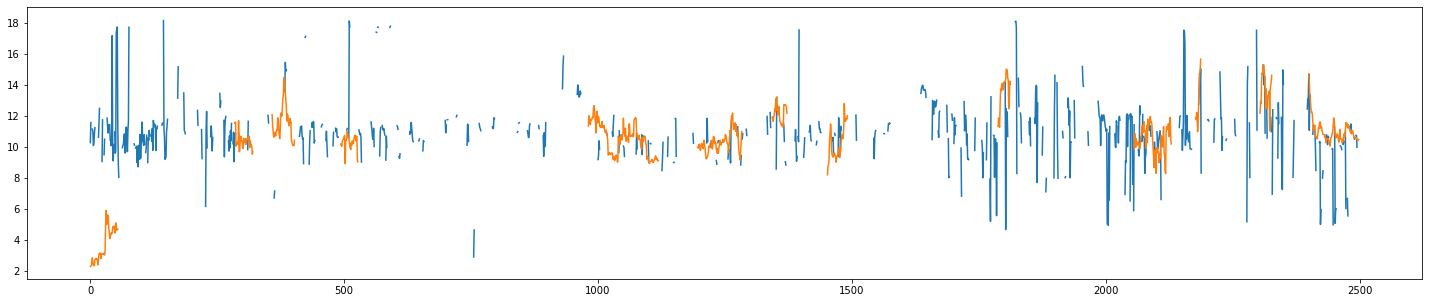

In [185]:
plt.figure(figsize=(25,5))
df_global_tracks[n]['z'].replace(0, np.nan).plot()
df_new[n]['z'].plot()

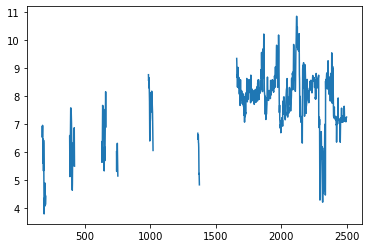

# DEBUGGING: Initialize neurons, and add tracklets in a loop

In [10]:
# Which fdnc neuron corresponds to which training tracklet?

In [11]:
from DLC_for_WBFM.utils.nn_utils.fdnc_predict import generate_templates_from_training_data

In [12]:
physical_unit_conversion = project_data.project_config.get_physical_unit_conversion_class()

In [13]:
templates = generate_templates_from_training_data(project_data, physical_unit_conversion)

In [14]:
df = project_data.df_training_tracklets
training_names = list(df.columns.levels[0])
n0 = training_names[0]
df[n0]

coords,z,x,y,likelihood,raw_neuron_id,brightness_red,volume
0,11.938685,460.630640,579.105540,0.509339,106.0,34641.0,1071.0
1,11.768766,459.930506,587.662247,0.603110,98.0,31600.0,895.0
2,11.694199,462.653889,592.806141,0.608984,99.0,32374.0,886.0
3,12.027528,464.391869,594.488130,0.497688,94.0,34583.0,995.0
4,12.081451,464.859793,591.918236,0.439350,98.0,35248.0,1049.0
5,11.942532,471.557482,591.241745,0.520358,99.0,35707.0,1072.0
6,11.679048,481.950944,582.005162,0.464217,101.0,34675.0,988.0
7,11.342823,493.994361,570.197761,0.469542,104.0,36357.0,1062.0
8,11.205919,507.679739,555.131667,0.525858,95.0,38962.0,1138.0
9,11.016922,512.228516,540.371411,0.529176,89.0,41485.0,1224.0


In [15]:
from DLC_for_WBFM.utils.external.utils_pandas import dataframe_to_dataframe_zxy_format
from DLC_for_WBFM.utils.external.utils_pandas import dataframe_to_numpy_zxy_single_frame

In [17]:
dataframe_to_dataframe_zxy_format(project_data.df_training_tracklets.iloc[[0], :]).to_numpy().reshape(-1, 3).shape

(144, 3)

In [18]:
project_data.get_centroids_as_numpy_training(0).shape

(144, 3)

In [ ]:
from DLC_for_WBFM.utils.training_data.tracklet_to_DLC import build_subset_df_from_tracklets

In [ ]:
df = project_data.df_training_tracklets

In [ ]:
dataframe_to_numpy_zxy_single_frame(df, t=0).shape

In [ ]:
# df_train = build_subset_df_from_tracklets(df, project_data.which_training_frames)
df.shape

In [ ]:
err

In [ ]:
from DLC_for_WBFM.utils.pipeline.tracklet_class import TrackedWorm
from DLC_for_WBFM.utils.training_data.tracklet_to_DLC import translate_training_names_to_raw_names
from tqdm.auto import tqdm

In [ ]:
tracklets_and_neurons_class = project_data.tracklets_and_neurons_class
worm_obj = TrackedWorm(detections=tracklets_and_neurons_class, verbose=1)
df_training_data = project_data.df_training_tracklets

In [ ]:
worm_obj.initialize_neurons_from_training_data(df_training_data)

In [ ]:
worm_obj

In [ ]:
# For each neuron:
# Calculate initial similarity to other tracklets based on global tracking (leifer fdnc)

In [ ]:
from DLC_for_WBFM.utils.pipeline.long_range_matching import b_matching_via_node_copying
from DLC_for_WBFM.utils.postprocessing.combine_tracklets_and_DLC_tracks import calc_global_track_to_tracklet_distances
from DLC_for_WBFM.utils.postprocessing.combine_tracklets_and_DLC_tracks import _unpack_tracklets_for_combining
from DLC_for_WBFM.utils.external.utils_pandas import dataframe_to_standard_zxy_format
from DLC_for_WBFM.utils.postprocessing.postprocessing_utils import distance_between_2_tracks, num_inliers_between_tracks

In [ ]:
project_cfg = project_data.project_config
training_cfg = project_cfg.get_training_config()
track_config = project_cfg.get_tracking_config()
use_imputed_df = False
start_from_manual_matches = False

In [ ]:
d_max, df_global_tracks, df_tracklets, min_overlap, output_df_fname, \
    keep_only_tracklets_in_final_tracks, global2tracklet, used_names,\
    allowed_tracklet_endpoint_wiggle = _unpack_tracklets_for_combining(
        project_cfg, training_cfg, track_config, use_imputed_df, start_from_manual_matches)

# Match tracklets to global neurons (which have noisy tracks)
global_neuron_names = list(df_global_tracks.columns.levels[0])
num_initial_tracklets = int(df_tracklets.shape[1]/4)
num_initial_matches = len(used_names)

verbose = 0

# Pre-make coordinates so that the dataframe is not continuously indexed
coords = ['z', 'x', 'y']
all_tracklet_names = list(df_tracklets.columns.levels[0])
list_tracklets_zxy = [df_tracklets[name][coords].to_numpy() for name in all_tracklet_names]

In [ ]:
i = 2
global_name = global_neuron_names[i]
print(global_name)
# for i, global_name in enumerate(tqdm(global_neuron_names)):

# TODO: use confidence of dlc tracks
this_global_track = df_global_tracks[global_name][coords].to_numpy()

this_global_track.shape

In [ ]:
# df_global_tracks

In [ ]:
# i = 0
# names = worm_obj.neuron_names
# this_neuron = names[i]

# df_this_global_track = worm_obj.get_tracklets_for_neuron(this_neuron)[0]

In [ ]:
# coords = ['z', 'x', 'y']
# df_this_global_track[coords]

In [ ]:
list_tracklets_zxy[0].shape

In [ ]:
# TODO: make the tracklets the proper length before this
# this_global_track = this_global_track[:-1, :]
# dist = calc_global_track_to_tracklet_distances(this_global_track, list_tracklets_zxy, used_names,
#                                       all_tracklet_names,
#                                       min_overlap=min_overlap)

# break
# previous_matches = global2tracklet[global_name]
# covering_time_points = get_already_covered_indices(df_tracklets, previous_matches)
# out = calc_covering_from_distances(dist, df_tracklets, used_names,
#                                    covering_time_points=covering_time_points,
#                                    covering_tracklet_names=previous_matches,
#                                    allowed_tracklet_endpoint_wiggle=allowed_tracklet_endpoint_wiggle,
#                                    d_max=d_max, verbose=verbose)
# # covering_time_points, covering_ind, these_dist = out
# _, _, covering_names, df_tracklets = out
# # all_covering_ind.append(covering_ind)
# global2tracklet[global_name].extend(covering_names)
# used_names.update(covering_names)
# # used_indices.update(covering_ind)

### Which neuron in the global track correponds to which training tracklet?

The training tracklets (and the associated global neuron) should have at least 10 inliers between the training tracklet... unless the templates could not be self-matched by fdnc, which is quite possible

In [ ]:
all_inlier_nums = []
for zxy in tqdm(list_tracklets_zxy):
    
    out = num_inliers_between_tracks(this_global_track[:-1,:], zxy, inlier_threshold=5)
    all_inlier_nums.append(out)

In [ ]:
tracklets_with_inliers = np.where(np.array(all_inlier_nums) > 0)[0]
names_with_inliers = [all_tracklet_names[i] for i in tracklets_with_inliers]

In [ ]:
plt.plot(all_inlier_nums, 'o')

In [ ]:
tracklets_of_global_neurons = translate_training_names_to_raw_names(df_training_data)

In [ ]:
for i in range(len(tracklets_of_global_neurons)):
    this_global_tracklet = tracklets_of_global_neurons[i]
    if this_global_tracklet in names_with_inliers:
        print(i, this_global_tracklet)
        break
else:
    print("None of the training data tracklets had ANY inliers for this global track")

### Fix indexing offset caused by empty volumes

In [ ]:
all_frame_dict = project_data.raw_frames

In [ ]:
all_zxy = {k: f.neuron_locs for k, f in all_frame_dict.items()}

In [ ]:
plt.plot(list(map(len, all_zxy.values())))

In [ ]:
empty_ind = []
for k, v in all_zxy.items():
    if v is None:
        empty_ind.append(k)

In [ ]:
# Create empty rows at each index, then reset the index
# Note: if there sequential indices that are missed, then the new indices need to be BEFORE the current dataframe
# e.g.:
#  Current dataframe has 90, 91, 92
#  But, 91 and 92 are empty and need to be inserted back in
#  Therefore the new temporary indices for the empty rows should be 90.1, 90.2 (or something between 90 and 91)
#  But if 94 was then empty (but not 93), the new index should be 94.5
#
# BUT it also should be done sequentially, because an empty 94.5 only makese sense if the previous empty 91 and 92 are filled

df_tracklets_new = df_tracklets.copy()
for i in tqdm(empty_ind):    
    new_empty_row = pd.DataFrame(np.nan, columns=df_tracklets.columns, index=[i+0.5])
    df_tracklets_new = df_tracklets_new.append(new_empty_row, ignore_index=False)
    df_tracklets_new = df_tracklets_new.sort_index().reset_index(drop=True)

In [ ]:
df_tracklets_new.shape, df_tracklets.shape

In [ ]:
df_tracklets_new.index.astype(int)

In [ ]:
all_dist = dist
all_summarized_dist = list(map(lambda x: np.nanquantile(x, 0.1), all_dist ))
i_sorted_by_median_distance = np.argsort(all_summarized_dist)

all_summarized_dist_sorted = np.sort(all_summarized_dist)

In [ ]:
i_sorted_by_median_distance

In [ ]:
all_summarized_dist_sorted[:10]

In [ ]:
plt.plot(all_dist[i_sorted_by_median_distance[3]])

In [ ]:
# Then loop through the tracklets and attempt to add
# Important: check using the per-neuron classifier

In [ ]:
# translate_training_names_to_raw_names(df_training_data)

In [ ]:
fname = "/scratch/zimmer/Charles/dlc_stacks/worm10-gui_test/2-training_data/all_tracklets.h5"
df_raw = pd.read_hdf(fname)

In [ ]:
df_raw.shape

In [ ]:
project_data.segmentation_metadata.num_frames

In [ ]:
len(project_data.segmentation_metadata.which_frames)

In [ ]:
project_data.segmentation_metadata.volumes_with_no_neurons

# Scratch: refactor subset df

In [ ]:
df = project_data.df_all_tracklets

In [ ]:
which_slices = [0, 1, 2]

In [ ]:
df_time_subset = df.loc(axis=1)[:, 'z'].iloc[which_slices]

In [ ]:
isnan_idx = df_time_subset.isna().sum() == 0
isnan_idx

In [ ]:
isnan_idx = isnan_idx.droplevel(1)

In [ ]:
to_keep = [idx for idx in isnan_idx.index if isnan_idx[idx]]
to_drop = [idx for idx in isnan_idx.index if not isnan_idx[idx]]

In [ ]:
to_keep[:3]

In [ ]:
df[to_keep].columns.levels[0]

In [ ]:
df2 = df[to_keep].copy()
# df2 = df.drop(to_drop, axis=1)
# df2.sort_index(inplace=True)

In [ ]:
df2.columns.levels[0]

In [ ]:
# df2.columns

In [ ]:
# df2.reindex(columns=to_keep, level=0).columns.levels[0]

In [ ]:
df_time_subset = df.loc(axis=1)[:, 'z'].loc[which_frames]
isnan_idx = df_time_subset.isna().sum() == 0
isnan_idx = isnan_idx.droplevel(1)
to_keep = [idx for idx in isnan_idx.index if isnan_idx[idx]]

df_subset = df_tracklets[to_keep]
df_subset = df_subset.reindex(columns=to_keep, level=0)  # Otherwise the dropped names remain

In [ ]:
isnan_idx['tracklet_0014983']

In [ ]:
df_time_subset

In [ ]:
# Refactor to get luts
from DLC_for_WBFM.utils.projects.utils_neuron_names import name2int_neuron_and_tracklet
from DLC_for_WBFM.utils.training_data.tracklet_to_DLC import build_subset_df_from_tracklets

In [ ]:
df2 = build_subset_df_from_tracklets(df_raw, which_frames)

In [ ]:
tracklet_names = list(df2.columns.levels[0])

all_matches = {}
for t in which_frames:
    matches = []
    for name in tracklet_names:
        global_ind = name2int_neuron_and_tracklet(name) + 1
        neuron_df = df2[name]
        raw_neuron_id = neuron_df['raw_neuron_id'].at[t]
        matches.append([global_ind, int(raw_neuron_id)])
    all_matches[t] = matches
    

In [ ]:
# all_matches

In [ ]:

# for name in tracklet_names:
#     # print(df2[name]['raw_neuron_id'].loc[which_frames])
#     print(df2[[name]].loc[which_frames])

# Scratch: Expand training data function

In [ ]:
from DLC_for_WBFM.utils.projects.utils_project import safe_cd
import os
from DLC_for_WBFM.utils.training_data.tracklet_to_DLC import get_or_recalculate_which_frames
from DLC_for_WBFM.utils.training_data.tracklet_to_DLC import build_subset_df_from_tracklets

In [ ]:
cfg = project_data.project_config
segment_cfg = cfg.get_segmentation_config()
training_cfg = cfg.get_training_config()
keep_raw_segmentation_index = True
DEBUG=False

In [ ]:
num_frames = cfg.config['dataset_params']['num_frames']

# Get ALL matches to the segmentation, then subset
with safe_cd(cfg.project_dir):
    # TODO: not hardcoded
    fname = os.path.join('raw', 'clust_df_dat.pickle')
    fname = training_cfg.resolve_relative_path(fname, prepend_subfolder=True)
    df = pd.read_pickle(fname)

    # Get the frames chosen as training data, or recalculate
    which_frames = get_or_recalculate_which_frames(DEBUG, df, num_frames, training_cfg)
    # logging.log(f"Which frames to use for training data: {which_frames}")

    # Build a sub-df with only the relevant neurons; all slices
    # Todo: connect up to actually tracked z slices?
    subset_opt = {'which_z': None,
                  'max_z_dist': None,
                  'verbose': 1}
    subset_df = build_subset_df_from_tracklets(df, which_frames, **subset_opt)


In [ ]:
# %debug

In [ ]:
# subset_df

In [ ]:
from DLC_for_WBFM.utils.pipeline.tracklet_pipeline import postprocess_and_build_matches_from_config
from DLC_for_WBFM.utils.pipeline.tracklet_pipeline import _unpack_config_for_tracklets
from DLC_for_WBFM.utils.pipeline.tracklet_pipeline import postprocess_and_build_tracklets_from_matches

In [ ]:
project_config = project_data.project_config
segmentation_config = project_config.get_segmentation_config()
training_config = project_config.get_training_config()

In [ ]:
# all_frame_dict, all_frame_pairs, z_threshold, min_confidence, segmentation_metadata = \
#         _unpack_config_for_tracklets(training_config, segmentation_config)

# # Sanity check
# val = len(all_frame_pairs)
# expected = project_config.config['dataset_params']['num_frames'] - 1
# msg = f"Incorrect number of frame pairs ({val} != {expected})"
# assert val == expected, msg

# # Calculate and save in both raw and dataframe format
# df_custom_format = postprocess_and_build_tracklets_from_matches(all_frame_dict, all_frame_pairs,
#                                                                 z_threshold, min_confidence)

In [ ]:
training_config.config